# Biodiversity in US national parks

### Abstract

We will be analysing observation data from several US national parks, and investigating how these data compare with the methods used to estimate species populations in national parks.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

## 0 - Limitations of observation data

The data we are using has been manufactured by Codecademy for the purposes of this project. National parks would likely use such data to extrapolate population counts for each species. We do not know what method was used, so we cannot be sure of the reliability of the data or any extrapolations. Later on, we will compare extrapolated population counts to real population counts for these parks, as well as comparing them to the conservation status. 

We will assume that the data is collected from real life studies. The data contains observations on plant and animal life, so we can assume that at least two method of observation have been used. We will assume that the intention of the observers is to count each animal once. In this case, it is possible tha some animals may have been under or over-counted. It is also possible that some animals/plants may have been misattributed to the wrong species.


## 1 - Species diversity

count how many unique species are in each park. break down into category, to see which categories are the most/least diverse in each park. compare this to the total observation count across all species (per park).

Let us convert observations.csv and species_info.csv into dataframes, and look at the first five rows of each.

In [10]:
observations = pd.read_csv('observations.csv')
print(observations.head())
species_info = pd.read_csv('species_info.csv')
print(species_info.head())

            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               Yosemite National Park           138
3      Abutilon theophrasti                  Bryce National Park            84
4  Githopsis specularioides  Great Smoky Mountains National Park            85
  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic 

We want to check if scientific_name and common_names are 1-to-1 in the species_info dataframe.

In [12]:
species_info.groupby('common_names')['scientific_name'].nunique().sort_values(ascending=False)


common_names
Dicranum Moss                                                          7
Brachythecium Moss                                                     7
Panic Grass                                                            6
Sphagnum                                                               6
Bryum Moss                                                             6
                                                                      ..
Eared Grebe                                                            1
Eagle Fern, Hairy Brackenfern, Western Bracken, Western Brackenfern    1
Dyer's Woad                                                            1
Dwarf Willow                                                           1
Jepson's Willow                                                        1
Name: scientific_name, Length: 5504, dtype: int64

In [13]:
species_info.groupby('scientific_name')['common_names'].nunique().sort_values(ascending=False)


scientific_name
Columba livia                          3
Holcus lanatus                         3
Streptopelia decaocto                  3
Hypochaeris radicata                   3
Puma concolor                          3
                                      ..
Equisetum laevigatum                   1
Equisetum hyemale ssp. affine          1
Equisetum fluviatile                   1
Epipactis gigantea                     1
Zygodon viridissimus var. rupestris    1
Name: common_names, Length: 5541, dtype: int64

This indicates to us that each common name, or group of common names, may be applied to multiple seperate scientific names, and vice versa.

In [15]:
species_info[species_info['common_names'].str.contains('velvetgrass', case=False, na=False)]

,category,scientific_name,common_names,conservation_status
2242,Vascular Plant,Holcus lanatus,"Common Velvet Grass, Velvetgrass",NaN
4236,Vascular Plant,Holcus lanatus,"Common Velvetgrass, Yorkshire-Fog",NaN
5600,Vascular Plant,Holcus lanatus,"Common Velvetgrass, Velvetgrass, Yorkshire Fog",NaN


We can also see that each common_name entry might be a single name, or a list of names, and that we may effectively have duplicate entries. 

What we want to do is split **common_names** by comma, then redo species_info so that every scientific name has every common name associated with it in it's **common_names** column.

### 1.1 - Data cleaning: reconstituting **species_info**

In [18]:
species_info['common_names'] = species_info['common_names'].astype(str)
species_info['common_names'] = species_info['common_names'].str.split(',')

exploded = species_info.explode('common_names')
exploded['common_names'] = exploded['common_names'].str.strip()
exploded = exploded[exploded['common_names'] != '']

cleaned_species_info = (
     exploded.groupby(['scientific_name'])['common_names'].apply(lambda names: ', '.join(sorted(set(names)))).reset_index())

cleaned_species_info

,scientific_name,common_names
0,Abies bifolia,Rocky Mountain Alpine Fir
1,Abies concolor,"Balsam Fir, Colorado Fir, Concolor Fir, Silver..."
2,Abies fraseri,Fraser Fir
3,Abietinella abietina,Abietinella Moss
4,Abronia ammophila,"Wyoming Sand Verbena, Yellowstone Sand Verbena"
...,...,...
5536,Zonotrichia leucophrys gambelii,Gambel's White-Crowned Sparrow
5537,Zonotrichia leucophrys oriantha,Mountain White-Crowned Sparrow
5538,Zonotrichia querula,Harris's Sparrow
5539,Zygodon viridissimus,Zygodon Moss


Now we want to redifine the **species_info** to have these exhaustive lists of common_names

In [20]:
species_info = species_info.drop(columns=['common_names'])

species_info = pd.merge(species_info, cleaned_species_info, on='scientific_name', how='left')



In [42]:
#Reording our columns
species_info = species_info[['category', 'scientific_name', 'common_names', 'conservation_status']]

#Check for duplicates
species_info[species_info.duplicated(subset=['scientific_name'], keep=False)].sort_values(by='scientific_name')

,category,scientific_name,common_names,conservation_status
5553,Vascular Plant,Agrostis capillaris,"Colonial Bent, Colonial Bentgrass, Rhode Islan...",NaN
2132,Vascular Plant,Agrostis capillaris,"Colonial Bent, Colonial Bentgrass, Rhode Islan...",NaN
2134,Vascular Plant,Agrostis gigantea,"Black Bent, Redtop, Water Bentgrass",NaN
5554,Vascular Plant,Agrostis gigantea,"Black Bent, Redtop, Water Bentgrass",NaN
4178,Vascular Plant,Agrostis mertensii,"Arctic Bentgrass, Northern Agrostis, Northern ...",NaN
...,...,...,...,...
5643,Vascular Plant,Vulpia myuros,"Foxtail Fescue, Rat-Tail Fescue, Rat-Tailed Fe...",NaN
2331,Vascular Plant,Vulpia octoflora,"Annual Fescue, Eight-Flower Six-Weeks Grass, P...",NaN
4290,Vascular Plant,Vulpia octoflora,"Annual Fescue, Eight-Flower Six-Weeks Grass, P...",NaN
3347,Vascular Plant,Zizia aptera,"Golden Alexanders, Heart-Leaf Alexanders, Hear...",NaN


As expected, there are many duplicates, which will now be dropped.

In [49]:
species_info = species_info.drop_duplicates(subset=['scientific_name'], keep='first')
species_info

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Domestic Cattle (Feral), Domesticated...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,"Rocky Mountain Elk, Wapiti Or Elk",NaN
...,...,...,...,...
5819,Vascular Plant,Solanum parishii,Parish's Nightshade,NaN
5820,Vascular Plant,Solanum xanti,"Chaparral Nightshade, Purple Nightshade",NaN
5821,Vascular Plant,Parthenocissus vitacea,"Thicket Creeper, Virginia Creeper, Woodbine",NaN
5822,Vascular Plant,Vitis californica,"California Grape, California Wild Grape",NaN


We have tidied up the common_names, so that each species has an exhau

How many unique species have we got, and how many national parks do we have data for?

In [33]:
unique_species = observations.scientific_name.nunique()
print(unique_species)
no_of_parks = observations.park_name.nunique()
print(no_of_parks)

5541
4


That's a lot of species! It won't do listing them all, but let's look at how many parks we're working with.

In [84]:
parks = observations.park_name.unique()
parks

array(['Great Smoky Mountains National Park', 'Yosemite National Park',
       'Bryce National Park', 'Yellowstone National Park'], dtype=object)

Now lets see how many distinct species each park has.

In [41]:
unique_species_per_park = observations.groupby('park_name')['scientific_name'].nunique()
unique_species_per_park

park_name
Bryce National Park                    5541
Great Smoky Mountains National Park    5541
Yellowstone National Park              5541
Yosemite National Park                 5541
Name: scientific_name, dtype: int64

We can see that each of our 5541 species is found in each park.

What species are observed overall vs in each park? We will start by merging **observations** with **species_info** so we can see the common names of each of these species.

In [62]:
observations_info = pd.merge(observations, species_info, on='scientific_name', how='left')
observations_info

,scientific_name,park_name,observations,category,common_names,conservation_status
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",NaN
1,Neovison vison,Great Smoky Mountains National Park,77,Mammal,American Mink,NaN
2,Prunus subcordata,Yosemite National Park,138,Vascular Plant,Klamath Plum,NaN
3,Abutilon theophrasti,Bryce National Park,84,Vascular Plant,Velvetleaf,NaN
4,Githopsis specularioides,Great Smoky Mountains National Park,85,Vascular Plant,Common Bluecup,NaN
...,...,...,...,...,...,...
25627,Croton monanthogynus,Yosemite National Park,173,Vascular Plant,Prairie Tea,NaN
25628,Otospermophilus beecheyi,Bryce National Park,130,Mammal,California Ground Squirrel,NaN
25629,Heterotheca sessiliflora ssp. echioides,Bryce National Park,140,Vascular Plant,Sessileflower False Goldenaster,NaN
25630,Dicranella rufescens,Yosemite National Park,171,Nonvascular Plant,Dicranella Moss,NaN


In [75]:
common_species = observations_info.groupby('scientific_name').agg({'common_names': 'first',
                                                                   'observations': 'sum'}).sort_values(by='observations', ascending=False)
common_species.head(10)

,common_names,observations
scientific_name,,
Streptopelia decaocto,Eurasian Collared-Dove,5355
Holcus lanatus,"Common Velvet Grass, Velvetgrass",5340
Castor canadensis,"American Beaver, Beaver",5175
Hypochaeris radicata,"Cat's Ear, Spotted Cat's-Ear",5160
Puma concolor,Panther (Mountain Lion),5133
Procyon lotor,"Common Raccoon, Raccoon",5076
Columba livia,Rock Dove,4959
Myotis lucifugus,"Little Brown Bat, Little Brown Myotis",4641
Bidens tripartita,"Stick-Tight, Three-Lobe Beggar-Ticks",2592


Let's create a bar graph of these 10 most populous species, and compare this with each parks top 10.

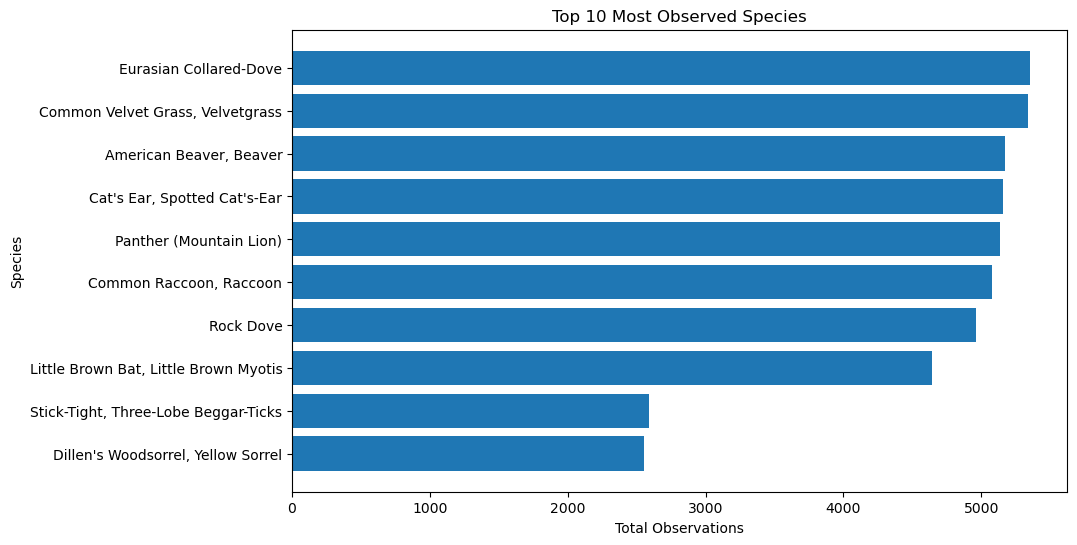

In [81]:
top_10 = common_species.head(10)

plt.figure(figsize=(10,6))
plt.barh(top_10['common_names'], top_10['observations'])
plt.xlabel('Total Observations')
plt.ylabel('Species')
plt.title('Top 10 Most Observed Species')
plt.gca().invert_yaxis()  # Highest on top
plt.show()


Now to do the same for each park.

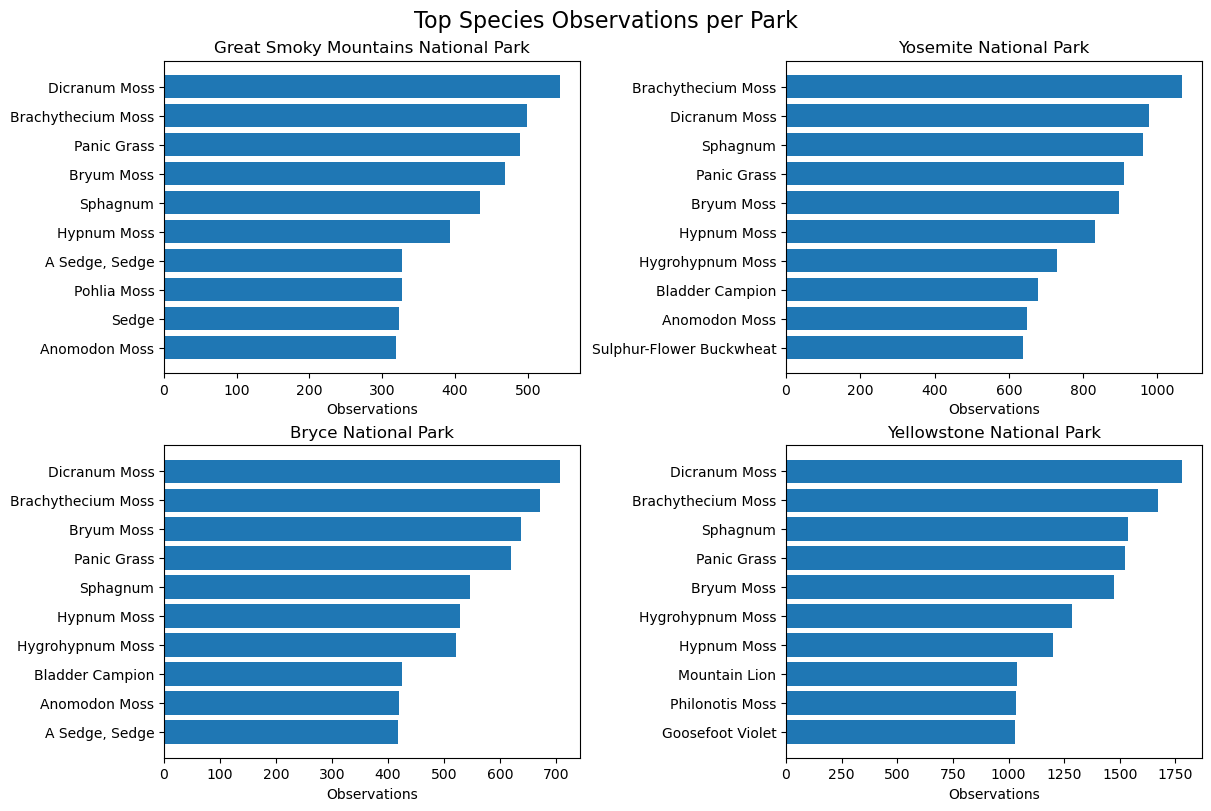

<Figure size 640x480 with 0 Axes>

In [92]:
#We know already that there are four parks. So we will plot a 2 by 2 grid of these four parks.
cols = 2
rows = 2

fig, axes = plt.subplots(rows, cols, figsize=(12, 8), constrained_layout=True)
axes = axes.flatten()

for i, park in enumerate(parks):
    ax = axes[i]
    subset = observations_info[observations_info['park_name'] == park]
    top_species = subset.groupby(['common_names'])['observations'].sum().sort_values(ascending=False).head(10)

    ax.barh(top_species.index, top_species.values)
    ax.set_title(park)
    ax.invert_yaxis()
    ax.set_xlabel('Observations')

plt.suptitle('Top Species Observations per Park', fontsize=16)
plt.show()
plt.clf()
    

And here are the top 10 rows of each of these dataframe:

In [113]:
for park in parks:
    print(f"\n===== {park} =====")
    parkdata = observations_info[observations_info['park_name'] == park]
    print(parkdata.groupby('scientific_name').agg({'common_names': 'first',
                                            'observations': 'sum'}).sort_values(by='observations', ascending=False).head(10))
    


===== Great Smoky Mountains National Park =====
                                                   common_names  observations
scientific_name                                                              
Streptopelia decaocto                    Eurasian Collared-Dove           768
Procyon lotor                           Common Raccoon, Raccoon           741
Castor canadensis                       American Beaver, Beaver           729
Puma concolor                           Panther (Mountain Lion)           717
Holcus lanatus                 Common Velvet Grass, Velvetgrass           648
Hypochaeris radicata               Cat's Ear, Spotted Cat's-Ear           585
Myotis lucifugus          Little Brown Bat, Little Brown Myotis           522
Columba livia                                         Rock Dove           507
Fragaria virginiana        Virginia Strawberry, Wild Strawberry           434
Microtus longicaudus   Coronation Island Vole, Long-Tailed Vole           424

===== Yosemite